## Caso 1: clasificación de enfermedades cardiovasculares
Partiendo del siguiente dataset con diversos factores, se pide
obtener un modelo basado en feed-forward para clasificar 
las personas según si han tenido o no una enfermedad
cardiovascular. A pesar de funcionar como una caja negra,
¿se podría obtener la implicación de cada atributo en el
resultado final?

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse

2024-02-03 11:40:07.333886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Definición de los metodos

In [3]:
def plot_grid(X, y, grid_size, labelNames):# Define the grid size
    # Create a figure to hold the images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 10))

    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate the index into the image array
            index = i * grid_size + j
            
            # Display the image
            axes[i, j].imshow(X[index], cmap='gray')
            
            # Remove the axis
            axes[i, j].axis('off')
            
            # Add a title with the label from y_train
            axes[i, j].set_title(f'Label: {labelNames[y[index][0]]}')

    # Show the plot
    plt.show()


def print_metrics(predictions, X_test, y_test, labelNames, H, epochs):

    print(classification_report(y_test.argmax(axis=1),	predictions.argmax(axis=1), target_names=labelNames))

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

Cargamos Dataset ejercicio 1

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Cargamos el dataset 
# Load the data from the file
data = pd.read_csv('data/SAheart.data')
# Quitamos la columna que no nos interesa
data.drop('row.names', axis=1, inplace=True)
#Comprobamos si hay valores nulos
data.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

Preparamos los datos para el entrenamiento

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Crear una instancia del codificador
label_encoder = LabelEncoder()

# Ajustar y transformar la columna categórica
column_encoded = label_encoder.fit_transform(data['famhist'])
data['famhist'] = column_encoded
#Pasamos a float32 todo
data = data.astype('float32')
# Convertimos valores a 0-1
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Separate the features (X) and the target variable (y)
X = data.drop('chd', axis=1)
y = data['chd']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print("Tamaño de X_train: ", X_train.shape[0])
print("Tamaño de X_test: ", X_test.shape[0])

print("Tamaño total del dataset: ", X_train.shape[0] + X_test.shape[0])


print("Porcentaje de datos de entrenamiento: ", X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))
print("Porcentaje de datos de test: ", X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]))


Tamaño de X_train:  369
Tamaño de X_test:  93
Tamaño total del dataset:  462
Porcentaje de datos de entrenamiento:  0.7987012987012987
Porcentaje de datos de test:  0.2012987012987013


In [39]:
# Contar el numero de casos diferentes en una lista
unique, counts = np.unique(y_train, return_counts=True)
print("Numero de casos y su distribucion en el dataset de entrenamiento: ", dict(zip(unique, counts)))

Numero de casos y su distribucion en el dataset de entrenamiento:  {0.0: 243, 1.0: 126}


In [114]:
print(X_train.dtypes)
print(X_test.dtypes)
X_train.head()
y_train.head()


sbp          float32
tobacco      float32
ldl          float32
adiposity    float32
famhist      float32
typea        float32
obesity      float32
alcohol      float32
age          float32
dtype: object
sbp          float32
tobacco      float32
ldl          float32
adiposity    float32
famhist      float32
typea        float32
obesity      float32
alcohol      float32
age          float32
dtype: object


411    0.0
265    0.0
57     1.0
199    0.0
175    1.0
Name: chd, dtype: float32

Preparación de los datos de entrada

### Diseño de la Red Neuronal

Llegados a este punto, hemos preparado los datos de entrada, por lo que los requisitios para el diseño de la RN serán:

 - Debe tener **9** neuronas en la capa de **entrada**
 - Debe tener **1** neuronas en la capa de **salida** con true or false
 - Necesitamos una función de activacion de clasificacion multicalse -> **softmax**


In [116]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(9,)))  # 9 características
model.add(Dropout(0.3))  # Regularización para evitar el sobreajuste
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria



In [137]:
sgd = SGD(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
H = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=50)


Epoch 1/150
6/6 [==============================] - 1s 46ms/step - loss: 0.5286 - accuracy: 0.7458 - val_loss: 0.5822 - val_accuracy: 0.6351
Epoch 2/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5314 - accuracy: 0.7051 - val_loss: 0.5835 - val_accuracy: 0.6351
Epoch 3/150
6/6 [==============================] - 0s 9ms/step - loss: 0.5344 - accuracy: 0.7186 - val_loss: 0.5834 - val_accuracy: 0.6351
Epoch 4/150
6/6 [==============================] - 0s 9ms/step - loss: 0.5229 - accuracy: 0.7288 - val_loss: 0.5824 - val_accuracy: 0.6351
Epoch 5/150
6/6 [==============================] - 0s 9ms/step - loss: 0.5080 - accuracy: 0.7153 - val_loss: 0.5848 - val_accuracy: 0.6351
Epoch 6/150
6/6 [==============================] - 0s 9ms/step - loss: 0.5485 - accuracy: 0.7322 - val_loss: 0.5824 - val_accuracy: 0.6351
Epoch 7/150
6/6 [==============================] - 0s 8ms/step - loss: 0.5371 - accuracy: 0.7254 - val_loss: 0.5832 - val_accuracy: 0.6351
Epoch 8/150
6/6 [=========

##### Haciendo inferencia con el modelo entrenado

In [138]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5135008096694946
Test accuracy: 0.7849462628364563


### Analizando el entrenamiento

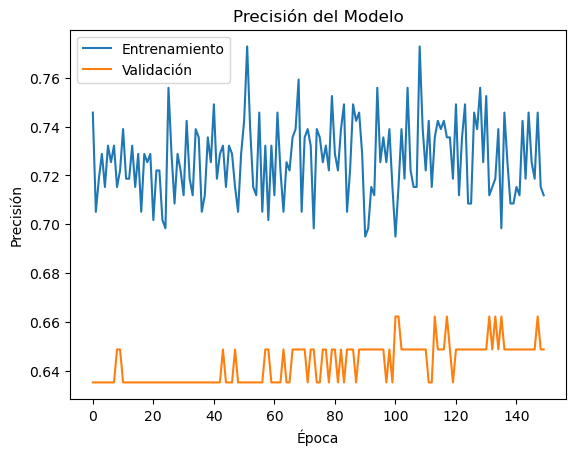

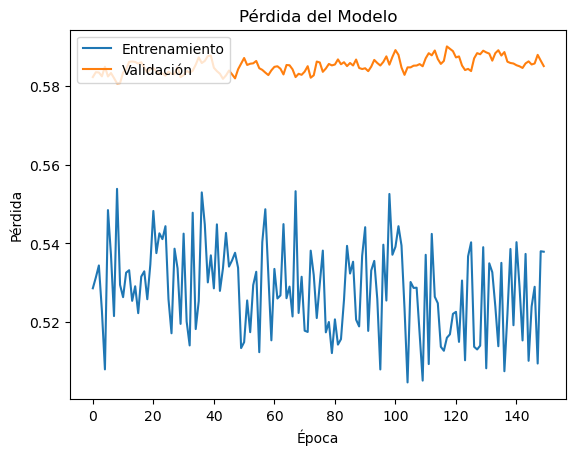

Pérdida en el Test: 0.5135008096694946
Precisión en el Test: 0.7849462628364563


In [140]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

# Pérdida
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

score = model.evaluate(X_test, y_test, verbose=0)
print("Pérdida en el Test:", score[0])
print("Precisión en el Test:", score[1])

In [141]:
# Probamos el modelo, primero preparamos los datos de test
#  X_test esté preprocesado de la misma manera que los datos de entrenamiento
predictions = model.predict(X_test).flatten()
# Las predicciones están en formato de probabilidad, por lo que puedes redondearlas para obtener 0 o 1
predictions = (predictions > 0.5).astype(int)

3/3 [==============================] - 0s 2ms/step


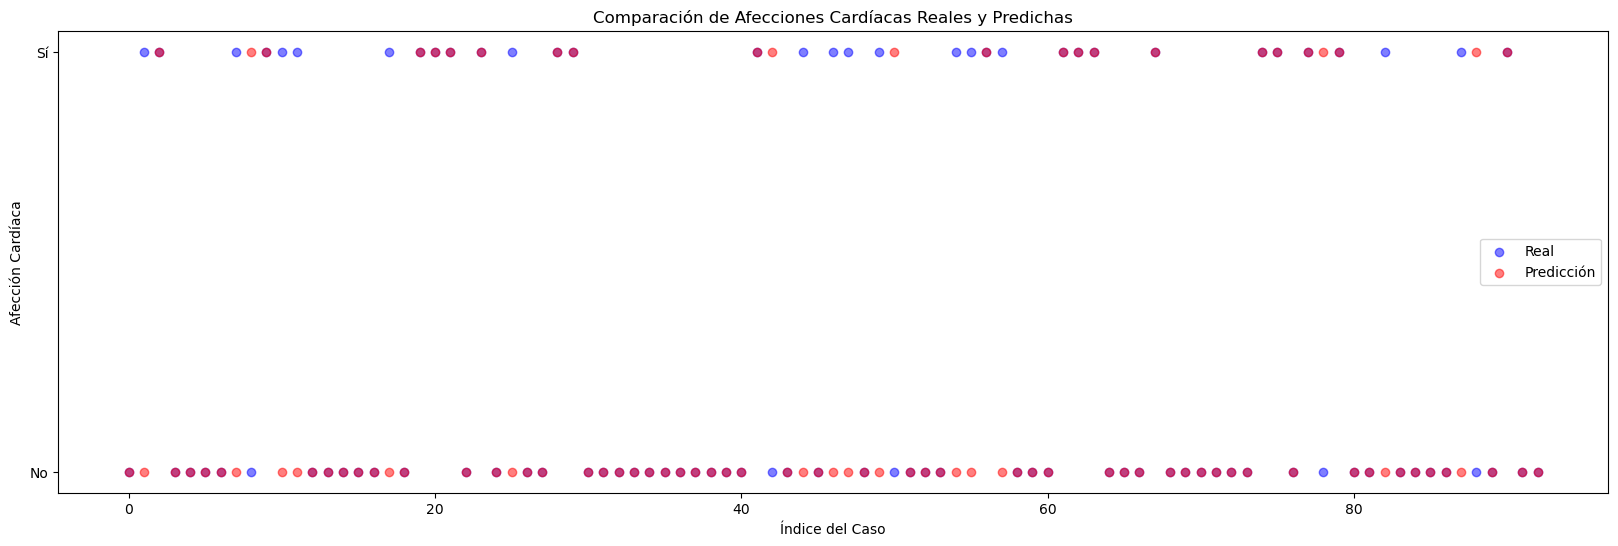

In [142]:
results = pd.DataFrame({'Real': y_test, 'Predicción': predictions})
results = results.reset_index(drop=True)  # Resetear el índice para un mejor gráfico

# Gráfico de dispersión
plt.figure(figsize=(20,6))
plt.scatter(results.index, results['Real'], color='blue', alpha=0.5, label='Real')
plt.scatter(results.index, results['Predicción'], color='red', alpha=0.5, label='Predicción')
plt.xlabel('Índice del Caso')
plt.ylabel('Afección Cardíaca')
plt.yticks([0, 1], ['No', 'Sí'])
plt.title('Comparación de Afecciones Cardíacas Reales y Predichas')
plt.legend()
plt.show()


Como vemos el modelo para su uso no es muy preciso, he peobado con más épocas y cambiando la red y no he conseguido grandes resultados, deberíanmos tener una muestra más grande para poder entrenar mejor el modelo. 